In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, make_scorer
)
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [213]:
df = pd.read_csv('C:/Users/USER/Desktop/hr_clean.csv')
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,PromotionRate,TrainRate,SwitchRate,IsRecentlyPromoted,IsNewInRole,IsNewInCompany,IsFemaleLowSatisfaction,Age_YearsAtCompany,JobSatisfaction_MonthlyIncome,YearsWithCurrManager_JobInvolvement
0,41,1,Travel_Rarely,1,2,Life Sciences,2,1,3,2,...,1.945910,0.000000,2.502170,1,0,0,0,79.782316,34.794057,15
1,49,0,Travel_Frequently,8,1,Life Sciences,3,0,2,2,...,1.416236,0.882899,0.294300,1,0,0,1,117.496868,17.086112,14
2,37,1,Travel_Rarely,2,2,Other,4,0,2,1,...,0.000000,3.000000,1.948405,1,1,1,0,0.000000,22.936193,0
3,33,0,Travel_Frequently,3,4,Life Sciences,4,1,3,1,...,0.920768,0.938314,0.312771,0,0,0,0,72.508411,23.927725,0
4,27,0,Travel_Rarely,2,1,Medical,1,0,3,1,...,0.523495,1.429516,3.055083,0,0,0,1,29.662532,16.303243,6


In [214]:
df = pd.get_dummies(df, columns=['BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus'], drop_first=True).astype(int)  
df.head()

,Age,Attrition,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1,2,2,1,3,2,4,8,...,0,0,0,0,0,0,1,0,0,1
1,49,0,8,1,3,0,2,2,2,8,...,0,0,0,0,0,1,0,0,1,0
2,37,1,2,2,4,0,2,1,3,7,...,0,1,0,0,0,0,0,0,0,1
3,33,0,3,4,4,1,3,1,3,7,...,0,0,0,0,0,1,0,0,1,0
4,27,0,2,1,1,0,3,1,2,8,...,0,1,0,0,0,0,0,0,1,0


In [215]:
# Optional: suppress future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

X = df.drop(columns=['Attrition'])
y = df['Attrition']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_acc_list, test_acc_list = [], []
precision_list, recall_list, f1_list = [], [], []
y_test_all, y_pred_all, y_proba_all = [], [], []

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # ➤ Apply SMOTE only on training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # ➤ Scale after resampling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    clf = SVC(kernel='linear', C=0.5, gamma=0.001, class_weight='balanced', 
              probability=True, random_state=42)
    clf.fit(X_train_scaled, y_train_resampled)

    # Predictions on test and train sets
    y_pred_test = clf.predict(X_test_scaled)
    y_pred_train = clf.predict(X_train_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Accuracy scores
    test_acc = accuracy_score(y_test, y_pred_test)
    train_acc = accuracy_score(y_train_resampled, y_pred_train)

    # Other evaluation metrics on test set
    prec = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred_test)
    y_proba_all.extend(y_proba)

    print(f"\nFold {fold} —")
    print(f"Train Accuracy: {train_acc:.4f} and Test Accuracy: {test_acc:.4f}")
    #print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# Report averages
print("\n--- Average Results Across Folds ---")
print(f"Average Train Accuracy: {np.mean(train_acc_list):.4f}")
print(f"Average Test Accuracy: {np.mean(test_acc_list):.4f}")
print(f"Average Precision: {np.mean(precision_list):.4f}")
print(f"Average Recall: {np.mean(recall_list):.4f}")
print(f"Average F1 Score: {np.mean(f1_list):.4f}")

print("\n--- CONFUSION_MATRIX ---")
print(confusion_matrix(y_test_all, y_pred_all))



Fold 1 —
Train Accuracy: 0.9245 and Test Accuracy: 0.8673
Precision: 0.8554, Recall: 0.8673, F1: 0.8587

Fold 2 —
Train Accuracy: 0.9306 and Test Accuracy: 0.8435
Precision: 0.8224, Recall: 0.8435, F1: 0.8282

Fold 3 —
Train Accuracy: 0.9168 and Test Accuracy: 0.8776
Precision: 0.8686, Recall: 0.8776, F1: 0.8715

Fold 4 —
Train Accuracy: 0.9209 and Test Accuracy: 0.8639
Precision: 0.8487, Recall: 0.8639, F1: 0.8521

Fold 5 —
Train Accuracy: 0.9168 and Test Accuracy: 0.8605
Precision: 0.8527, Recall: 0.8605, F1: 0.8559

--- Average Results Across Folds ---
Average Train Accuracy: 0.9219
Average Test Accuracy: 0.8626
Average Precision: 0.8495
Average Recall: 0.8626
Average F1 Score: 0.8533

--- CONFUSION_MATRIX ---
[[1164   69]
 [ 133  104]]


In [216]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Features and target
X = df.drop(columns=['Attrition'])
y = df['Attrition']

# Define pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, class_weight='balanced', random_state=42))
])

# Define parameter grid
param_grid = {
    'svc__C': [0.1, 0.5, 1, 5, 10],
    'svc__gamma': [0.001, 0.01, 0.1],
    'svc__kernel': ['rbf', 'linear'] 
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',  # choose main metric for model selection
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit
grid_search.fit(X, y)

# Results
print("\n--- Best Parameters ---")
print(grid_search.best_params_)
print("\n--- Best F1 Score ---")
print(grid_search.best_score_)

# Best estimator predictions (optional evaluation)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

--- Best Parameters ---
{'svc__C': 0.5, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}

--- Best F1 Score ---
0.8532843606661265


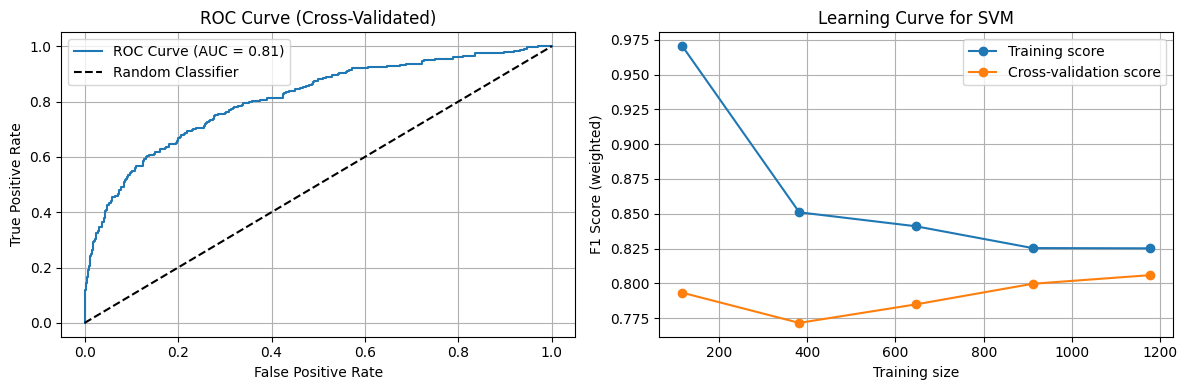

In [217]:
# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_all, y_proba_all)
roc_auc = auc(fpr, tpr)

# Scale the full feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_scaled, y, cv=5, scoring='f1_weighted', n_jobs=-1)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot ROC Curve
axs[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve (Cross-Validated)')
axs[0].legend()
axs[0].grid(True)

# Plot Learning Curve
axs[1].plot(train_sizes, train_scores_mean, 'o-', label='Training score')
axs[1].plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
axs[1].set_xlabel('Training size')
axs[1].set_ylabel('F1 Score (weighted)')
axs[1].set_title('Learning Curve for SVM')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
